# Task Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Paris Housing Price Prediction. Feature distributions are close to, but not exactly the same, as the original.
The task is to predict the price, i.e. regression.
Submissions are scored on the root mean squared error. 

# Installation and importing of necessary libraries

In [44]:
import os
os.system("pip3 install lazypredict > /dev/null 2>&1")

0

In [2]:
# Import necessary libraries and functions

# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
plt.style.use('ggplot')
%matplotlib inline
import lazypredict
from lazypredict.Supervised import LazyRegressor
from scipy.stats import randint as sp_randint

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# EDA

## Loading datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')
print('Train set shape:',train.shape)
print('Test set shape:',test.shape)

Train set shape: (22730, 18)
Test set shape: (15154, 17)


In [4]:
train.describe()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00,22730.00
mean,11364.50,46586.22,48.24,0.48,0.45,47.31,50013.80,5.59,5.62,2008.01,0.47,0.46,5283.65,5067.98,530.47,0.46,5.15,4634456.90
std,6561.73,49521.24,28.23,0.50,0.50,47.78,30006.64,2.74,2.71,118.83,0.50,0.50,3047.08,3097.35,274.84,0.50,3.06,2925163.24
min,0.00,89.00,1.00,0.00,0.00,1.00,3.00,1.00,1.00,1990.00,0.00,0.00,4.00,1.00,4.00,0.00,0.00,10313.50
25%,5682.25,20392.75,25.00,0.00,0.00,25.00,22936.00,3.00,3.00,2000.00,0.00,0.00,2977.25,2599.00,297.00,0.00,3.00,2041739.10
50%,11364.50,44484.00,47.00,0.00,0.00,45.00,50414.00,6.00,6.00,2006.00,0.00,0.00,5359.00,4977.00,515.00,0.00,5.00,4450823.40
75%,17046.75,71547.00,75.00,1.00,1.00,69.00,76291.00,8.00,8.00,2014.00,1.00,1.00,7746.00,7652.00,767.00,1.00,8.00,7159919.50
max,22729.00,6071330.00,100.00,1.00,1.00,6000.00,491100.00,10.00,10.00,10000.00,1.00,1.00,91992.00,96381.00,9017.00,1.00,10.00,10004278.30


## Analyzing missing data in the datasets

In [5]:
print('Train missing data:',train.isna().sum(),'\n', 'Test missing data:',test.isna().sum())

Train missing data: id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64 
 Test missing data: id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
dtype: int64


Insight - no missing data in the dataset.

##  Concatinating train and test datasets

In [6]:
complete = pd.concat([test.assign(ind="test"), train.assign(ind="train")]) ## assigning markers for the test and train sets
complete.reset_index(level=0, inplace=True)
complete.head()

,index,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,ind,price
0,0,22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8,test,NaN
1,1,22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4,test,NaN
2,2,22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2,test,NaN
3,3,22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5,test,NaN
4,4,22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9,test,NaN


## Analysing distributions of numeric and continuous features

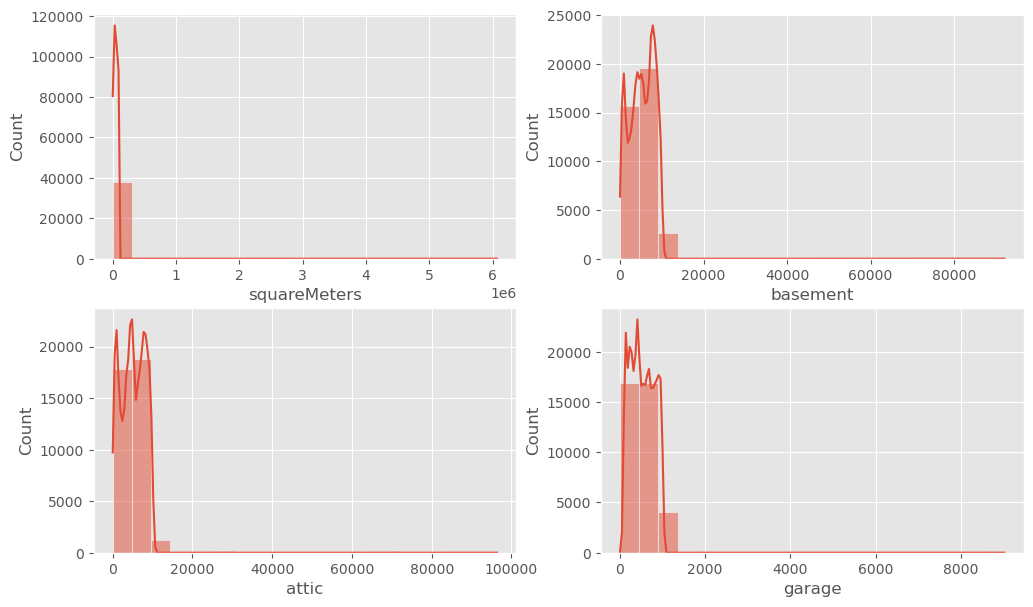

In [7]:
continious_features=["squareMeters",'basement', 'attic', 'garage']

# Plot expenditure features
fig=plt.figure(figsize=(12,7))
for i, var_name in enumerate(continious_features):
    ax=fig.add_subplot(2,2,i+1)
    sns.histplot(data=complete, x=var_name, bins=20, kde=True, alpha = 0.5)   

plt.show()

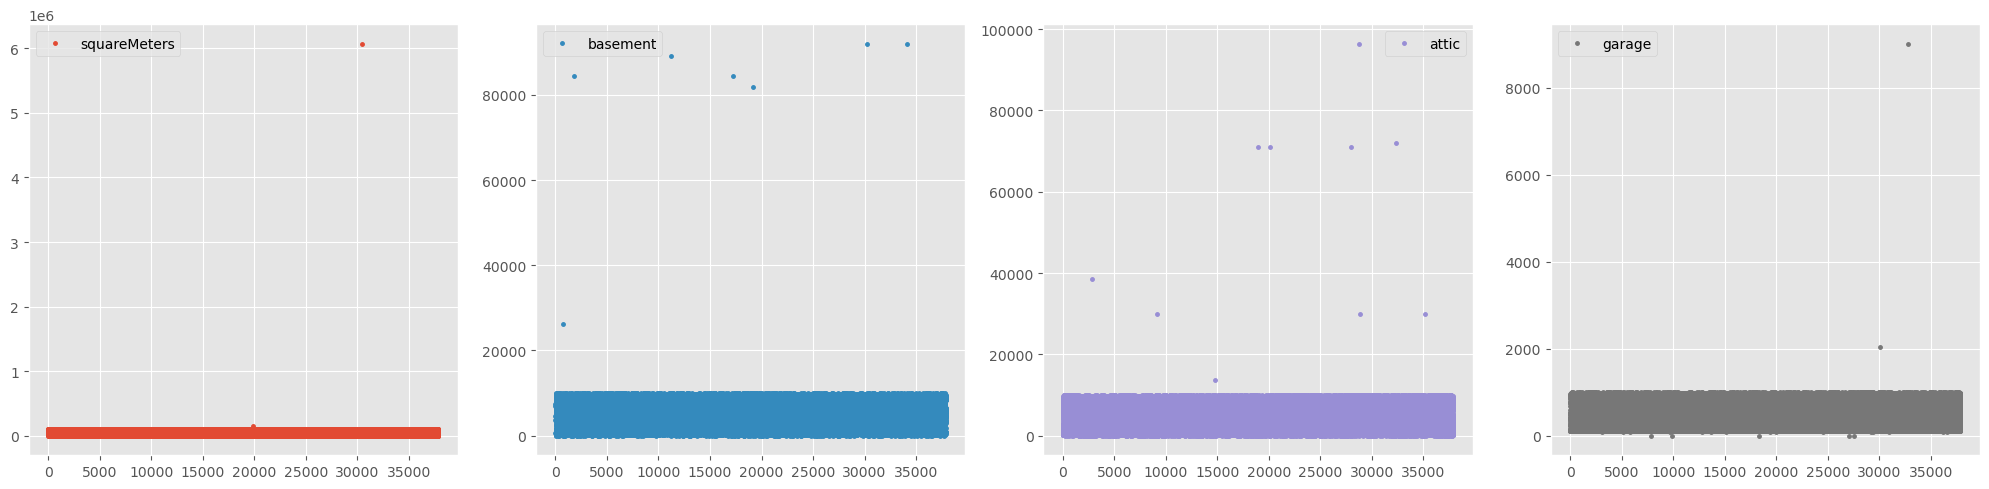

In [8]:
complete[continious_features].plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(20,5), markersize=5)
plt.tight_layout()

Insight:

Continuous variables definetely contain outliers that need to be adressed before modelling. For now we will replace the missing values with NaN. Afterwards we will look whether the outliers occur completely at random and choose an appropriate strategy for imputation.

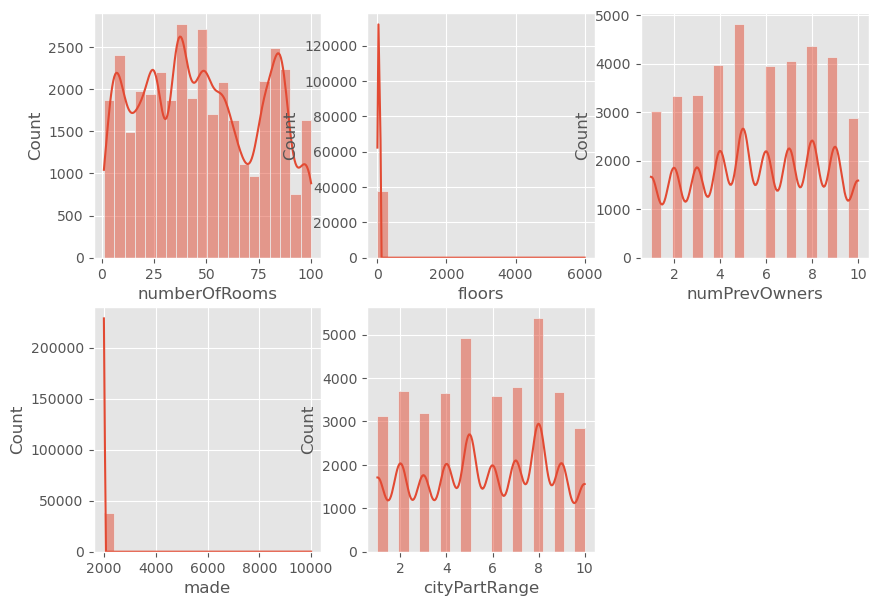

In [9]:
numeric_features=["numberOfRooms",'floors', 'numPrevOwners', 'made', 'cityPartRange']

# Plot expenditure features
fig=plt.figure(figsize=(10,7))
for i, var_name in enumerate(numeric_features):
    ax=fig.add_subplot(2,3,i+1)
    sns.histplot(data=complete, x=var_name, bins=20, kde=True, alpha = 0.5)   

plt.show()

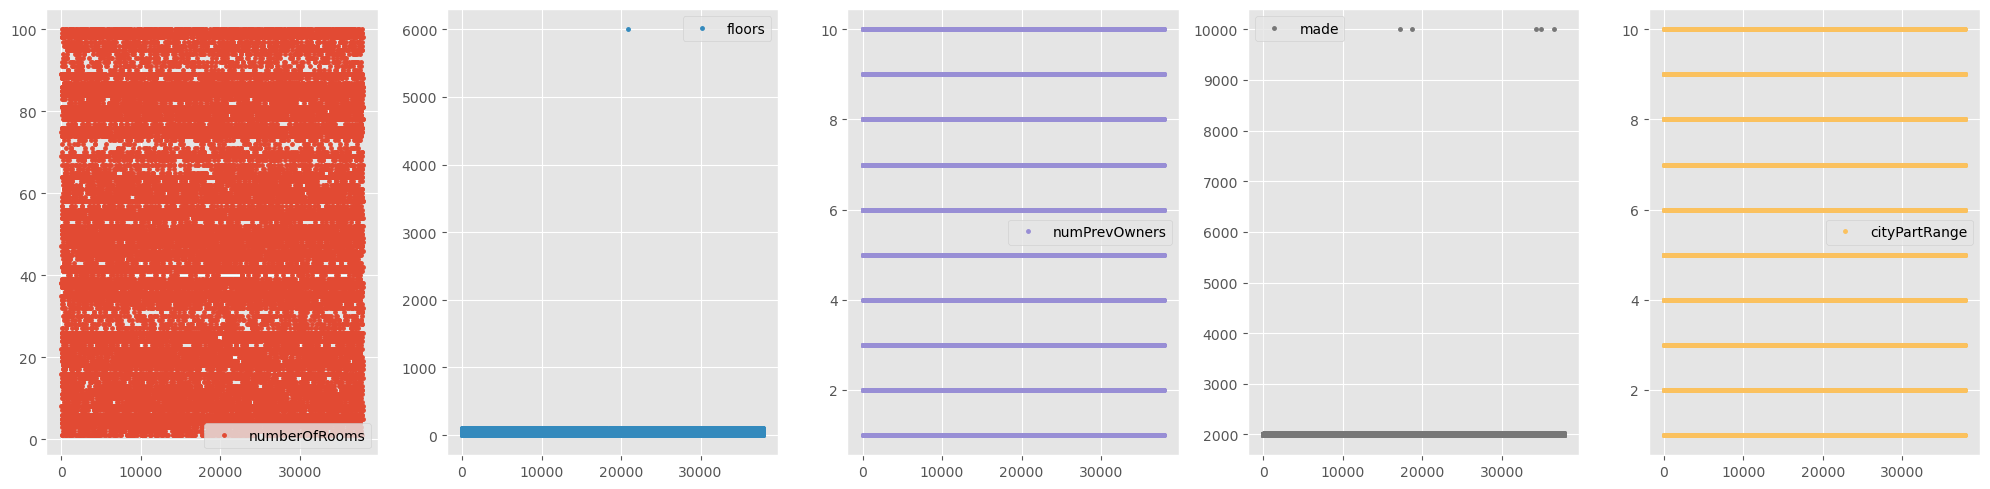

In [10]:
complete[numeric_features].plot(lw=0, marker=".", subplots=True, layout=(-1, 5),
          figsize=(20,5), markersize=5)
plt.tight_layout()

Insight:

Variables "number of rooms"and "number of previous owners" are okay. Variables "made", representing year of construction, as well as "floors" definetely need to be cleared from outliers, since unrealistic values are inserted: year 10000, floors 6000.  

## Detecting outliers

In [11]:
complete.loc[(complete['squareMeters']<=complete['squareMeters'].mean() - 2 * complete['squareMeters'].std()) | 
             (complete['squareMeters']>=complete['squareMeters'].mean() + 2 * complete['squareMeters'].std()), 'squareMeters']=np.nan
complete.loc[(complete['basement']<=complete['basement'].mean() - 2 * complete['basement'].std()) | 
             (complete['basement']>=complete['basement'].mean() + 2 * complete['basement'].std()), 'basement']=np.nan
complete.loc[(complete['attic']<=complete['attic'].mean() - 2 * complete['attic'].std()) | 
             (complete['attic']>=complete['attic'].mean() + 2 * complete['attic'].std()), 'attic']=np.nan
complete.loc[(complete['garage']<=complete['garage'].mean() - 2 * complete['garage'].std()) | 
             (complete['garage']>=complete['garage'].mean() + 2 * complete['garage'].std()), 'garage']=np.nan
complete.loc[(complete['floors']<=complete['floors'].mean() - 2 * complete['floors'].std()) | 
             (complete['floors']>=complete['floors'].mean() + 2 * complete['floors'].std()), 'floors']=np.nan
complete.loc[(complete['made']<=complete['made'].mean() - 2 * complete['made'].std()) | 
             (complete['made']>=complete['made'].mean() + 2 * complete['made'].std()), 'made']=np.nan

In [12]:
imputed_features = ['squareMeters', 'basement', 'attic', 'garage', 'floors', 'made']

print('Amount of detected outliers', 
      '\n',
      complete[imputed_features].isna().sum())

Amount of detected outliers 
 squareMeters     2
basement         7
attic           10
garage           2
floors           1
made             5
dtype: int64


In [13]:
print('rows with detected outliers:', 
      '\n',
      complete[imputed_features]\
      [complete[imputed_features].isna().sum(axis = 1)>=1])

rows with detected outliers: 
        squareMeters  basement   attic  garage  floors    made
696        28600.00       NaN 4831.00  874.00   85.00 2017.00
1789       44838.00       NaN 8252.00  865.00   85.00 2009.00
2838       47982.00   9727.00     NaN  327.00   38.00 1994.00
9148       14588.00   3333.00     NaN  357.00    2.00 2003.00
11191      43906.00       NaN 4409.00  675.00   79.00 2013.00
14769      52948.00   5397.00     NaN  104.00   13.00 1994.00
17261      28956.00       NaN 8777.00  655.00   35.00 2000.00
17267      68038.00   6537.00 6304.00  366.00   54.00     NaN
18762      80062.00    732.00 6475.00  758.00   35.00     NaN
18982      31357.00   1284.00     NaN  212.00   35.00 2017.00
19149      43758.00       NaN 9179.00  243.00   93.00 2008.00
19895           NaN   5953.00 8529.00 1000.00   88.00 2000.00
20063      26484.00    774.00     NaN  663.00   37.00 1997.00
20813      65029.00   5123.00  230.00  668.00     NaN 2012.00
28012      93278.00   4145.00     NaN  

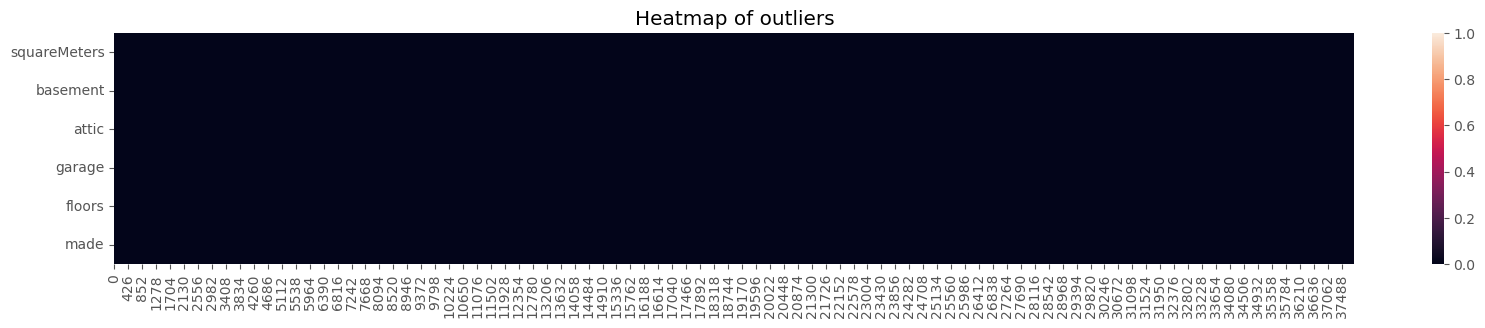

In [14]:
# generating heatmap of N/As
plt.figure(figsize=(20,3))
sns.heatmap(complete[imputed_features].isna().T)
plt.title('Heatmap of outliers')
plt.show()

In [15]:
# imputing with KNN
imputer = KNNImputer(n_neighbors=3)
KNN_imputation = imputer.fit_transform(complete[imputed_features])
complete[imputed_features] = KNN_imputation

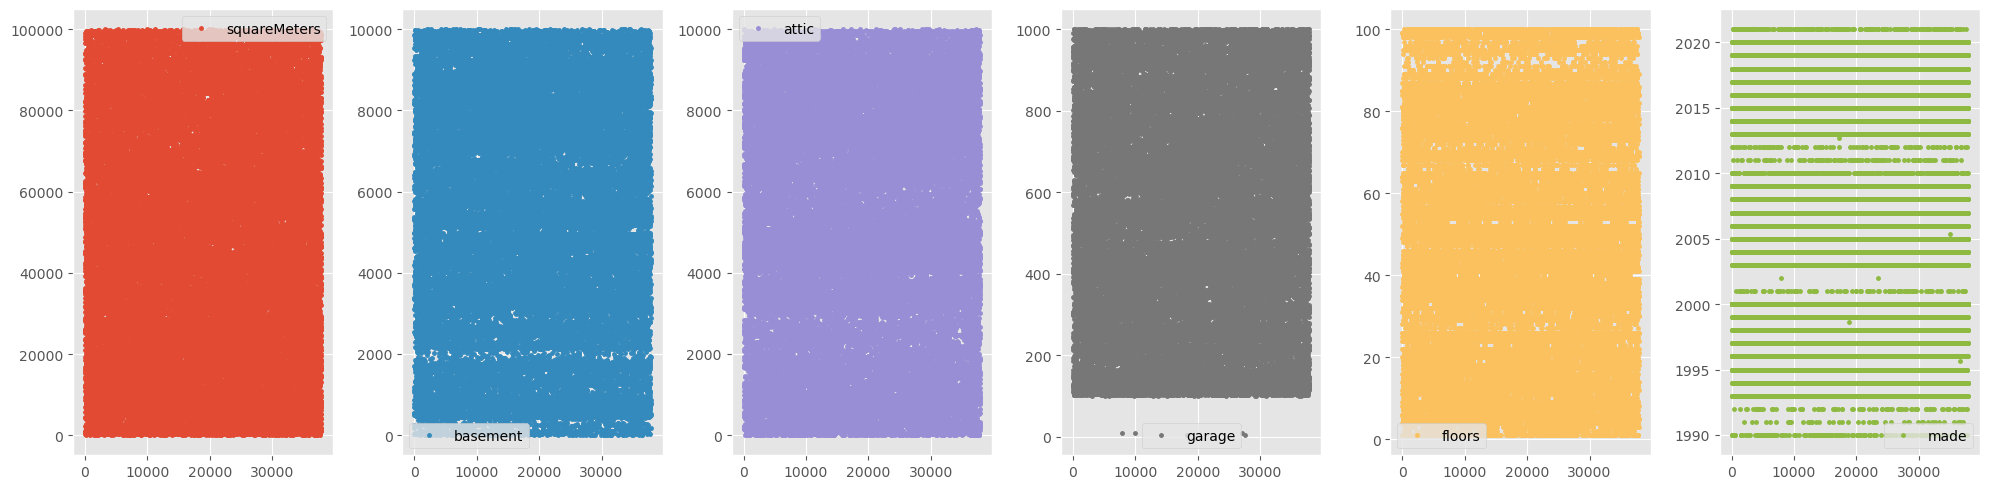

In [16]:
complete[imputed_features].plot(lw=0, marker=".", subplots=True, layout=(-1, 6),
          figsize=(20,5), markersize=5)
plt.tight_layout()

## Distribution after imputation

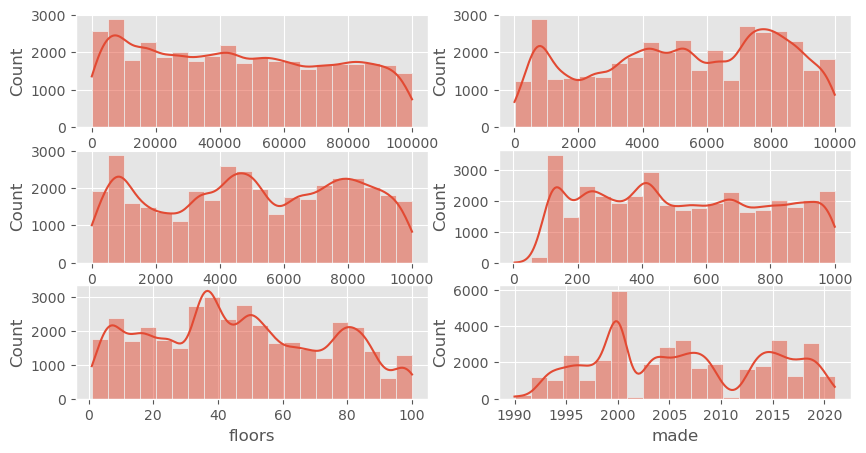

In [17]:
fig=plt.figure(figsize=(10,5))
for i, var_name in enumerate(imputed_features):
    ax=fig.add_subplot(3,2,i+1)
    sns.histplot(data=complete, x=var_name, bins=20, kde=True, alpha = 0.5)   
plt.show()

## cityCode variable

Under city code variable presumably  current postal codes (code postal) in France (FR) are meant. They range from 01000 – 95880. 

In [18]:
complete.loc[(complete['cityCode'] > 95880) | 
             (complete['cityCode'] < 1000), 'cityCode']=np.nan

print('Number of postal codes that are out of predefined range:', complete['cityCode'].isna().sum())

Number of postal codes that are out of predefined range: 2266


We might assume that the best predictor for this variable is "cityPartRange".
The strategy for impution will be  the most common value for the particular "cityPartRange".

Unique city codes: 8742


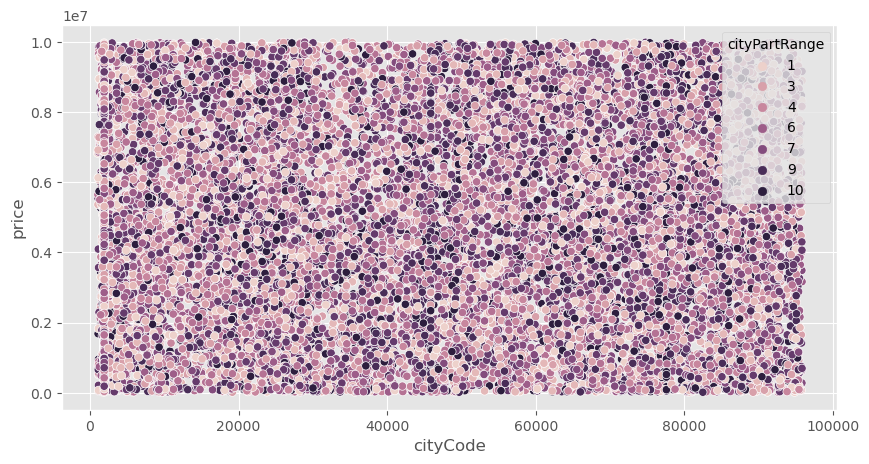

In [19]:
groups = complete.groupby('cityPartRange') # Grouping the DataFrame "complete" by 'cityPartRange'


mode_by_group = groups['cityCode'].transform(lambda x: x.mode()[0]) # Finding the mode of 'cityCode' for each group using the transform method and lambda function

complete['cityCode'] = complete['cityCode'].fillna(mode_by_group) # Filling the missing values in 'cityCode' with the mode of its corresponding group

plt.figure(figsize=(10,5))
sns.scatterplot(data = complete, y = 'price', x = 'cityCode', hue = 'cityPartRange')

# Printing the number of unique values in the 'cityCode' column of the DataFrame
print('Unique city codes:', complete['cityCode'].nunique())

The data in 'cityCode' variable is very sparse and does not show a clear relation to neither 'cityPartRange' nor 'price'. Therefore we will drop it from our model.

## Scaling the data

In [20]:
# Determining the list of features to scale by combining continious_features and numeric_features lists
features_to_scale = continious_features + numeric_features
features_to_scale.remove('cityPartRange') # Remove 'cityPartRange' from the list of features to scale
features_to_scale.remove('numPrevOwners') # Remove 'numPrevOwners' from the list of features to scale
print(features_to_scale)

# Creating an instance of StandardScaler() class from scikit-learn library
scaler = StandardScaler()

# Scaling the features in "complete" dataframe using StandardScaler() and creating a new dataframe with "_scaled" suffix
scaled_features = pd.DataFrame(scaler.fit_transform(complete[features_to_scale]), columns = [name + '_scaled' for name in features_to_scale])

# Concatenating the scaled features dataframe with the original dataframe, and dropping the original unscaled columns
scaled_complete = pd.concat([complete, scaled_features], axis = 1)
scaled_complete.drop(columns = features_to_scale, inplace = True)

# Dropping 'index', 'id', and 'cityCode' columns, and moving 'price' column to the beginning of the dataframe
scaled_complete.drop(columns = ['index', 'id', 'cityCode'], inplace = True)
scaled_complete.insert(0, 'price', scaled_complete.pop('price'))

# Printing the first five rows of the scaled dataframe
print(scaled_complete.head())

['squareMeters', 'basement', 'attic', 'garage', 'numberOfRooms', 'floors', 'made']
   price  hasYard  hasPool  cityPartRange  numPrevOwners  isNewBuilt  \
0    NaN        0        1              5              3           0   
1    NaN        0        0             10              3           1   
2    NaN        1        1              9              6           0   
3    NaN        1        1              6              5           1   
4    NaN        0        0              3              7           1   

   hasStormProtector  hasStorageRoom  hasGuestRoom   ind  squareMeters_scaled  \
0                  0               0             8  test                 0.05   
1                  1               1             4  test                 0.55   
2                  1               0             2  test                 1.52   
3                  1               1             5  test                -1.02   
4                  1               1             9  test                 0.73  

## Correlation of variables

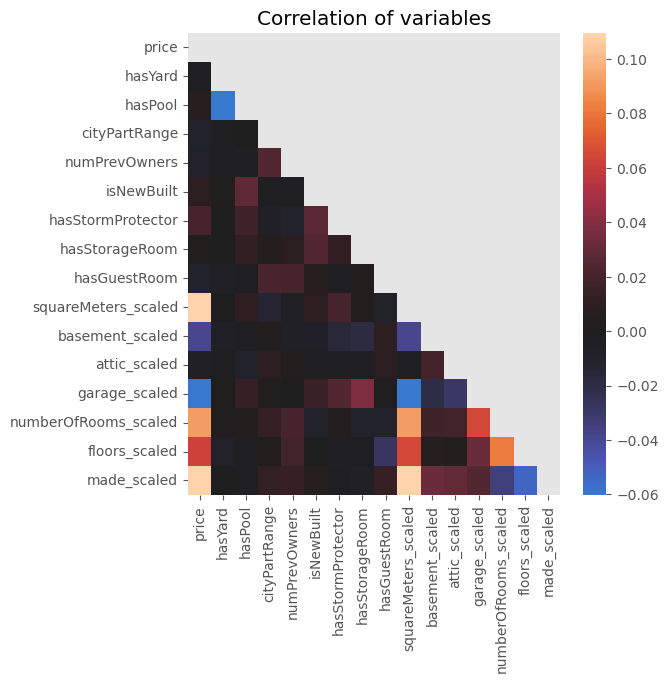

In [21]:
plt.figure(figsize = (6,6))
corr = scaled_complete.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True,center = 0,square = False) ## building correlation matrix
plt.title('Correlation of variables')
plt.show()

## Correlation of hasGuestRoom, cityPartRange, numPrevOwners variables to the price

Since hasGuestRoom, cityPartRange, numPrevOwners variables show no Pearson correlation to price, have a range of possible values, usage of these variables will hardly bring us much but might lead to overfitting.

We will look whether we find any patterns by the distribution of these variables and choose whether to drop them or not. 

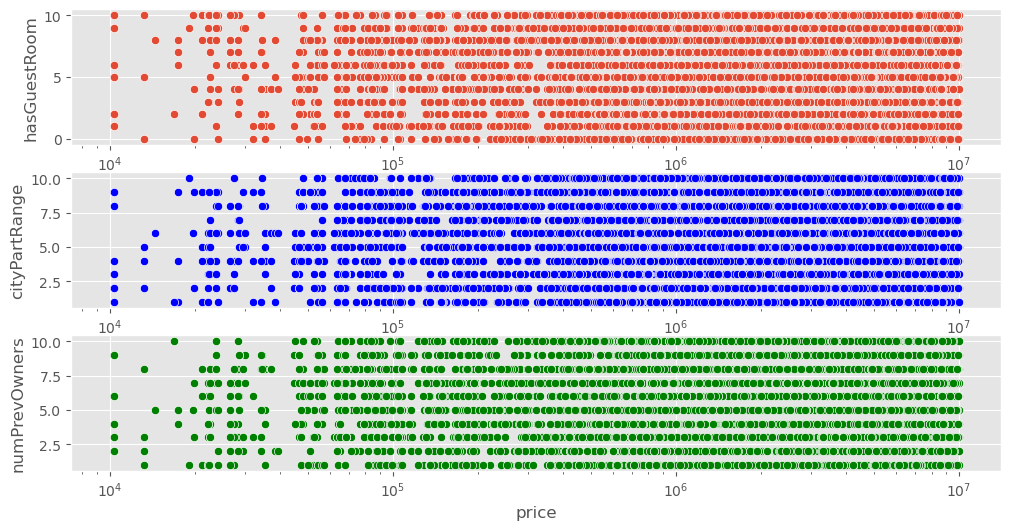

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
sns.scatterplot(data = scaled_complete, x = 'price', y = 'hasGuestRoom')
plt.xscale('log') ## log-scaling to observe patterns more clearly
plt.subplot(3,1,2)
sns.scatterplot(data = scaled_complete, x = 'price', y = 'cityPartRange' , color = 'blue')
plt.xscale('log') ## log-scaling to observe patterns more clearly
plt.subplot(3,1,3)
sns.scatterplot(data = scaled_complete, x = 'price', y = 'numPrevOwners' , color = 'green')
plt.xscale('log') ## log-scaling to observe patterns more clearly


In [23]:
print(scaled_complete.groupby('hasGuestRoom')['price'].mean(), '\n',
scaled_complete.groupby('cityPartRange')['price'].mean(), '\n',
scaled_complete.groupby('numPrevOwners')['price'].mean())

hasGuestRoom
0    4756098.40
1    4960423.76
2    4507272.37
3    4854884.59
4    4562208.92
5    4355964.20
6    4339299.61
7    4724658.69
8    4614394.73
9    4748685.74
10   4720653.70
Name: price, dtype: float64 
 cityPartRange
1    4739065.20
2    4648063.11
3    4793707.55
4    4573884.96
5    4528136.04
6    4549449.27
7    4790730.22
8    4606927.54
9    4522798.60
10   4682484.56
Name: price, dtype: float64 
 numPrevOwners
1    4637428.26
2    4811183.74
3    4868133.04
4    4541280.63
5    4514425.86
6    4613549.80
7    4554887.38
8    4444940.66
9    4690871.48
10   4824138.86
Name: price, dtype: float64


All three variables seem to be quite week predictors for the target variable. However, in order to be sure that they do not bring us much value for the final model we will analyse the performance of modelling on the datasets without these variables and including there one-hot-encoded version

## OneHotEncoder for the variables 'hasGuestRoom', 'cityPartRange', 'numPrevOwners'

In [24]:
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
OneHotEncoder_complete = pd.DataFrame(encoder.fit_transform(scaled_complete[['hasGuestRoom', 'cityPartRange', 'numPrevOwners']]).toarray())
OneHotEncoder_complete.columns = encoder.get_feature_names_out(['hasGuestRoom', 'cityPartRange', 'numPrevOwners'])

In [25]:
scaled_low_card = scaled_complete.drop(['hasGuestRoom', 'cityPartRange', 'numPrevOwners'] ,axis=1)
scaled_high_card = pd.concat([scaled_low_card, OneHotEncoder_complete], axis = 1)
scaled_low_card.head(3)

,price,hasYard,hasPool,isNewBuilt,hasStormProtector,hasStorageRoom,ind,squareMeters_scaled,basement_scaled,attic_scaled,garage_scaled,numberOfRooms_scaled,floors_scaled,made_scaled
0,NaN,0,1,0,0,0,test,0.05,0.57,1.08,-1.07,1.45,-1.44,-1.38
1,NaN,0,0,1,1,1,test,0.55,-0.24,1.44,-0.50,-0.36,1.49,-1.50
2,NaN,1,1,0,1,0,test,1.52,0.77,-0.82,-0.83,0.95,-0.36,-1.14


In [26]:
scaled_high_card.head(3)

,price,hasYard,hasPool,isNewBuilt,hasStormProtector,hasStorageRoom,ind,squareMeters_scaled,basement_scaled,attic_scaled,...,numPrevOwners_1,numPrevOwners_2,numPrevOwners_3,numPrevOwners_4,numPrevOwners_5,numPrevOwners_6,numPrevOwners_7,numPrevOwners_8,numPrevOwners_9,numPrevOwners_10
0,NaN,0,1,0,0,0,test,0.05,0.57,1.08,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,NaN,0,0,1,1,1,test,0.55,-0.24,1.44,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,1,1,0,1,0,test,1.52,0.77,-0.82,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


## Splitting datasets back to train and test. Creating train / validation splits. 

In [27]:
test_scaled_low_card, train_scaled_low_card = scaled_low_card[scaled_low_card["ind"].eq("test")], scaled_low_card[scaled_low_card["ind"].eq("train")]
test_scaled_high_card, train_scaled_high_card = scaled_high_card[scaled_high_card["ind"].eq("test")], scaled_high_card[scaled_high_card["ind"].eq("train")]
train_scaled_low_card.drop('ind', axis = 1, inplace = True)
test_scaled_high_card.drop('ind', axis = 1, inplace = True)
y_train_low_card, X_train_low_card, X_test_low_card = train_scaled_low_card["price"],  \
train_scaled_low_card.loc[:, train_scaled_low_card.columns != 'price'],\
test_scaled_low_card.loc[:, test_scaled_low_card.columns != 'price']
y_train_high_card, X_train_high_card, X_test_high_card = train_scaled_low_card["price"],\
train_scaled_high_card.loc[:, train_scaled_high_card.columns != 'price'],\
test_scaled_high_card.loc[:, test_scaled_high_card.columns != 'price']

In [28]:
X_train_low_card, X_val_low_card, y_train_low_card, y_val_low_card = \
train_test_split(X_train_low_card, y_train_low_card, test_size=0.2, random_state=42)
X_train_high_card, X_val_high_card, y_train_high_card, y_val_high_card = \
train_test_split(X_train_high_card, y_train_high_card, test_size=0.2, random_state=42)

# Models from Lazy Regressor

For time efficiency reasons we will look at the performance of first 15 models on both datasets.

In [29]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None, random_state=42, regressors =lazypredict.Supervised.REGRESSORS[:15])
models_low_card,predictions_low_card = reg.fit(X_train_low_card, X_val_low_card, y_train_low_card, y_val_low_card)
models_high_card,predictions_high_card = reg.fit(X_train_high_card, X_val_high_card, y_train_high_card, y_val_high_card)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 15/15 [02:12<00:00,  8.84s/it]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 15/15 [02:39<00:00, 10.61s/it]


In [30]:
models_low_card.head(5)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HuberRegressor,1.00,1.00,162603.25,0.24
BayesianRidge,1.00,1.00,162800.94,0.04
HistGradientBoostingRegressor,1.00,1.00,170377.36,0.52
ExtraTreesRegressor,1.00,1.00,176303.71,6.37
GradientBoostingRegressor,1.00,1.00,179941.92,3.41


In [31]:
models_high_card.head(5)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HuberRegressor,1.00,1.00,162601.18,0.72
BayesianRidge,1.00,1.00,163030.41,0.12
HistGradientBoostingRegressor,1.00,1.00,167870.53,0.83
GradientBoostingRegressor,1.00,1.00,185235.63,4.31
ExtraTreesRegressor,1.00,1.00,188259.76,13.93


Results are similar on both datasets. However it seems that more models perform well on the low cardinality dataset.
In order to prevent overfitting and improve time efficiency of the final model we will choose our low cardinality dataset for final model. 

## Using all models from Lazy Regressor for the better performer - low cardinality dataset

In [32]:
reg_final = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None, random_state=42, 
                          regressors = lazypredict.Supervised.REGRESSORS[:30] + lazypredict.Supervised.REGRESSORS[32:]) 
## we exclude model 31 (RF regressor) from the call because of the problems in the functionality of this call in lazypredictor at the moment
models_low_card,predictions_low_card = reg_final.fit(X_train_low_card, X_val_low_card, y_train_low_card, y_val_low_card)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 40/40 [04:30<00:00,  6.75s/it]


In [33]:
print(models_low_card.head(10))

                             Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                  
HuberRegressor                             1.00       1.00 162603.25   
PassiveAggressiveRegressor                 1.00       1.00 162604.97   
RANSACRegressor                            1.00       1.00 162661.68   
OrthogonalMatchingPursuitCV                1.00       1.00 162698.32   
OrthogonalMatchingPursuit                  1.00       1.00 162699.76   
LassoCV                                    1.00       1.00 162729.23   
LassoLarsCV                                1.00       1.00 162737.09   
LarsCV                                     1.00       1.00 162737.09   
LassoLarsIC                                1.00       1.00 162754.03   
LassoLars                                  1.00       1.00 162790.52   

                             Time Taken  
Model                                    
HuberRegressor                     0.26  
PassiveAg

## Calling RandomForestRegressor separately

In [34]:
regr = RandomForestRegressor(random_state=42)

regr.fit(X_train_low_card, y_train_low_card)
regr.score(X_val_low_card, y_val_low_card)
y_predict = regr.predict(X_val_low_card)
rmse = mean_squared_error(y_val_low_card, y_predict, squared=False)
print('RandomForestRegressor validation RMSE score:' , rmse)

RandomForestRegressor validation RMSE score: 211588.4261639787


The result  of RandomForestRegressor is week in comparison to the best models

# Hyperparameter tuning for the best baseline models

## Huber Regressor

In [35]:
Huberregressor = HuberRegressor()

# Define the hyperparameters to tune and the range of values to search over
param_grid_Huberregressor = {
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [0.5, 1.0, 1.5],
    'max_iter': [10, 25, 50, 75, 100]
}

# Use grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=Huberregressor, param_grid=param_grid_Huberregressor, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_low_card, y_train_low_card)

# Print the best hyperparameters and corresponding mean train score
print('Best hyperparameters:', grid_search.best_params_)

# Train a new model using the best hyperparameters on the full training set
best_regressor = grid_search.best_estimator_
best_regressor.fit(X_train_low_card, y_train_low_card)

# Evaluate the final model on the testing set
y_predict = best_regressor.predict(X_val_low_card)
test_score = best_regressor.score(X_val_low_card, y_val_low_card)
print('Best validation RMSE score:', mean_squared_error(y_val_low_card, y_predict, squared=False))
print('Test score R-squared:', test_score)

Best hyperparameters: {'alpha': 0.001, 'epsilon': 1.0, 'max_iter': 25}
Best validation RMSE score: 162587.17348242764
Test score R-squared: 0.9969413085792146


We managed to improve RMSE only slightly. It implies that this model performs good on standard parameters.

## Passive Aggressive Regressor

In [36]:
passive_aggressive_regressor = PassiveAggressiveRegressor(random_state = 42)

# Define the hyperparameters to tune and the range of values to search over
param_grid_PassiveAggressive = {
    'C': [0.1, 1.0],
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-4, 1e-5, 1e-6],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

# Use grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=passive_aggressive_regressor, param_grid=param_grid_PassiveAggressive, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_low_card, y_train_low_card)

# Print the best hyperparameters and corresponding mean train score
print('Best hyperparameters:', grid_search.best_params_)

# Train a new model using the best hyperparameters on the full training set
best_regressor = grid_search.best_estimator_
best_regressor.fit(X_train_low_card, y_train_low_card)

# Evaluate the final model on the testing set
y_predict = best_regressor.predict(X_val_low_card)
test_score = best_regressor.score(X_val_low_card, y_val_low_card)
print('Best validation RMSE score:', mean_squared_error(y_val_low_card, y_predict, squared=False))
print('Test score R-squared:', test_score)

Best hyperparameters: {'C': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 5000, 'tol': 0.0001}
Best validation RMSE score: 162607.54700809237
Test score R-squared: 0.996940541972216


The performance of the model is identical with best hyperparameters as well as with the standard. 

# Keras Tensorflow Regressor

## Using randomized search for Keras Tensorflow Regressor for identifying baseline model.

In [37]:
def create_model(neurons=128, learning_rate=0.01, activation1='relu', activation2='relu'):
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your regression model  
    model = Sequential()
    model.add(Dense(neurons, input_shape=X_train_low_card.shape[1:], activation=activation1, kernel_initializer='normal'))
    model.add(Dense(neurons // 2, activation=activation2, kernel_initializer='normal'))
    model.add(Dense(1, activation=None, kernel_initializer='normal'))

    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
  
    return model

# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameters to try out
params = {
    'neurons': [16,32,64,128,256],
    'activation1': ['tanh','relu', 'sigmoid'],
    'activation2': ['tanh','relu', 'sigmoid'], 
    'batch_size': [16, 32, 64],
    'learning_rate': [0.01, 0.001, 0.0001]
}

# Create a randomized search CV object passing in the parameters to try
random_search_keras = RandomizedSearchCV(model, param_distributions=params, n_iter=20, cv=3, verbose=0)

# Set up early stopping based on validation loss
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=3)

# Fit the object to our data
random_search_keras.fit(X_train_low_card, y_train_low_card, epochs=30, validation_data=(X_val_low_card, y_val_low_card),
                        callbacks=[monitor_val_loss])


# Evaluate the final model on the testing set
y_predict_keras = random_search_keras.predict(X_val_low_card)
test_score_keras = random_search_keras.score(X_val_low_card, y_val_low_card)
print('Best validation RMSE score:', mean_squared_error(y_val_low_card, y_predict_keras, squared=False))
print('Best hyperparameters:', random_search_keras.best_params_)

Best validation RMSE score: 1923011.1577046842
Best hyperparameters: {'neurons': 32, 'learning_rate': 0.0001, 'batch_size': 32, 'activation2': 'relu', 'activation1': 'relu'}


## Visualizing the results by different hyperparameters.

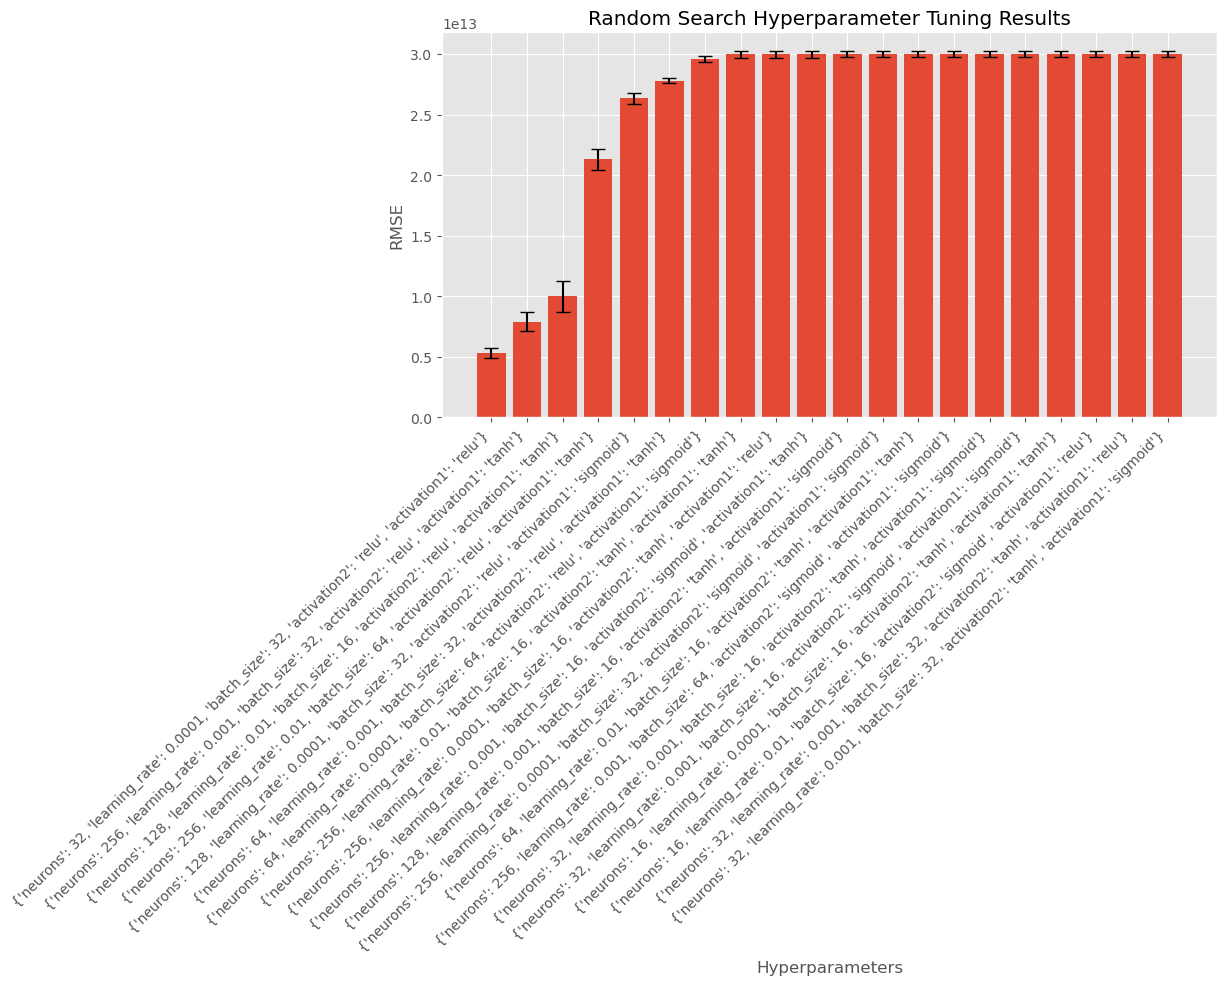

In [38]:
results = random_search_keras.cv_results_

# Extract the relevant information
params = [str(p) for p in results['params']]
mean_scores = -results['mean_test_score']
std_scores = results['std_test_score']

# Sort the hyperparameter combinations by RMSE score
sorted_idx = mean_scores.argsort()
params = [params[i] for i in sorted_idx]
mean_scores = mean_scores[sorted_idx]
std_scores = std_scores[sorted_idx]

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(params, mean_scores, yerr=std_scores, capsize=5)

# Set the chart title and axis labels
plt.title("Random Search Hyperparameter Tuning Results")
plt.xlabel("Hyperparameters")
plt.ylabel("RMSE")

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show the chart
plt.show()

## Adopting the result of best performers for the final grid search.

In [39]:
def create_model(neurons=128, learning_rate=0.01, activation1='relu', activation2='relu', random_state=42):
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your regression model  
    model = Sequential()
    model.add(Dense(neurons, input_shape=X_train_low_card.shape[1:], activation=activation1, kernel_initializer='normal'))
    model.add(Dense(neurons // 2, activation=activation2, kernel_initializer='normal'))
    model.add(Dense(1, activation=None, kernel_initializer='normal'))

    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
  
    return model

# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameters to try out
params = {
    'neurons': [64, 128, 256],
    'activation1': ['relu'],
    'activation2': ['relu'], 
    'batch_size': [8, 16, 32],
    'learning_rate': [0.01, 0.001, 0.0001]
}

# Create a grid search CV object passing in the parameters to try
grid_search_keras = GridSearchCV(model, param_grid=params, cv=3, verbose=0)

# Set up early stopping based on validation loss
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=3)

# Fit the object to our data
grid_search_keras.fit(X_train_low_card, y_train_low_card, epochs=30, validation_data=(X_val_low_card, y_val_low_card),
                        callbacks=[monitor_val_loss])


# Evaluate the final model on the testing set
y_predict_keras = grid_search_keras.predict(X_val_low_card)
test_score_keras = grid_search_keras.score(X_val_low_card, y_val_low_card)
print('Best validation RMSE score:', mean_squared_error(y_val_low_card, y_predict_keras, squared=False))
print('Best hyperparameters:', grid_search_keras.best_params_)

Best validation RMSE score: 163175.21664310785
Best hyperparameters: {'activation1': 'relu', 'activation2': 'relu', 'batch_size': 8, 'learning_rate': 0.0001, 'neurons': 128}


The performance of the Keras model is nearly equal to the performance of best models from LazyClassifier. However the best result was achieved through Huber Regressor and thefefore the final prediction will be made with this model.

# Final prediction and submission

In [42]:
test_scaled_low_card.drop(['price', 'ind'], axis = 1, inplace = True)
preds = best_regressor.predict(test_scaled_low_card)
test['price'] = preds
submission = test[['id','price']]
submission.to_csv('submission.csv', index = False)